In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.feature_extraction.text import TfidfVectorizer

# 목표
- 우리 서비스를 이용하고 있는 고객들의 **코호트 분석**을 통해 **신규 고객 유치와 재구매율**을 높일 수 있는 솔루션을 도출해내자

In [2]:
df = pd.read_csv("./data/online_retail.csv")

# EDA

## 컬럼정보

In [3]:
# InvoiceNo: 송장 번호. 명목, 각 거래에 고유하게 할당된 6자리 정수. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
# StockCode: 제품(품목) 코드. 명목, 각 고유한 제품에 고유하게 할당된 5자리 정수.
# Description: 제품(품목) 이름. 명목.
# Quantity: 거래당 각 제품(품목)의 수량. 숫자.
# InvoiceDate: 송장 날짜 및 시간. 숫자, 각 거래가 생성된 날짜와 시간.
# UnitPrice: 단가. 숫자, 파운드로 표시된 단위당 제품 가격.
# CustomerID: 고객 번호. 명목, 각 고객에게 고유하게 할당된 5자리 정수.
# Country: 국가 이름. 명목, 각 고객이 거주하는 국가의 이름. 
# TotalPrice : 해당 주문번호 총 금액입니다.(UnitPrice * CustomerID)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   TotalPrice   541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


## 결측치 확인

In [6]:
# 결측치 수
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
TotalPrice          0
dtype: int64

In [7]:
# 결측치 비율
df.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
TotalPrice     0.000000
dtype: float64

- Description, CustomerID 각각 1454, 135080 건의 결측치 확인
    - CustomerID의 결측치는 비회원 고객인 것으로 판단하였음
    - 상품명이 없는 주문 건수 1454회
    - 비회원 고객 주문 건수는 135080(약 25%)

## 카테고리별 고유값 확인

In [8]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
TotalPrice      5998
dtype: int64

- 총 25900 번의 송장 배송건이 있었음
- 상품코드와 제품명의 고유값 수가 일치하지 않음(각각 4070, 4223) -> 다른 상품이어도 같은 코드명으로 분리 되는 경우가 있는듯함 (결측값 포함하여 1607 종류의 차이가 있음)
     - 제품코드 기준으로 상품명 통일화 전처리 진행
         - 제품 코드를 기준으로 한 이유? : 1.제품명에는 결측값이 포함되어 있음 2. 고유값 수가 더 많은것을 기준으로 하면 고유값 수가 적은 쪽에서 새로운 결측값이 생길 수 있기 때문에
        

## 이상치 확인

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,17.987795
std,218.081158,96.759853,1713.600303,378.810824
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


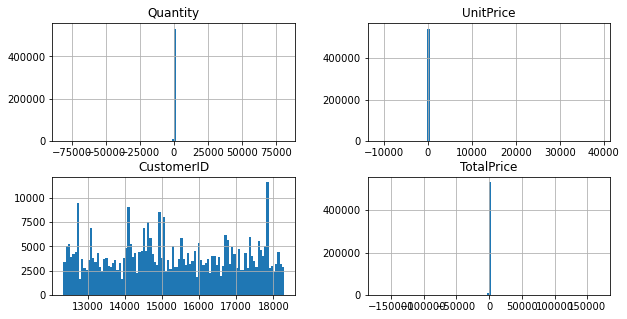

In [10]:
df.hist(figsize=(10, 5), bins=100);

- Quantity, UnitPrice, TotalPrice 에는 이상치가 있음 -> 대부분의 값은 각각 1 ~ 10, 1 ~ 5, 3 ~ 18 사이에 있음 

## 상품명 통일화
- 제품별 판매 빈도수 확인 하는 도중 이상한 이름의 제품명 확인
    - (ex : 85123A 이면 제품명이 ?,na, WHITE HANGING HEART T-LIGHT HOLDER, CREAM HANGING HEART T-LIGHT HOLDER)
- 동일한 제품 코드면 각 제품 코드별 최빈 제품명으로 통일

In [11]:
df[df['StockCode'] == '85123A']['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', '?',
       'wrongly marked carton 22804',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

In [12]:
# 제품 코드 기준으로 가장 많이 등장하는 상품명으로 통일화 진행
mode_function = lambda x: mode(x)[0][0]
df['Description'] = df.groupby('StockCode')['Description'].transform(mode_function)

<ipython-input-12-47ab5ea52f2e>:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_function = lambda x: mode(x)[0][0]
<ipython-input-12-47ab5ea52f2e>:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  mode_function = lambda x: mode(x)[0][0]


In [13]:
# 통일 후
df[df['StockCode'] == '85123A']['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER'], dtype=object)

- '85123A' 에 해당하는 상품 코드 
    - 전 : 'WHITE HANGING HEART T-LIGHT HOLDER', '?', 'wrongly marked carton 22804','CREAM HANGING HEART T-LIGHT HOLDER'
    - 후 : 'WHITE HANGING HEART T-LIGHT HOLDER'

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541725 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   TotalPrice   541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [15]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description       184
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
TotalPrice          0
dtype: int64

- 같은 제품코드 기준으로 제품명을 통일화 했지만 여전히 제품명에 NULL값 존재(184개)

### 제품명이 Null 인 제품코드 찾기

In [16]:
invoice_counts = df[df['Description'].isna()]['InvoiceNo'].value_counts()

In [17]:
print(invoice_counts.max())
print(invoice_counts.min())

1
1


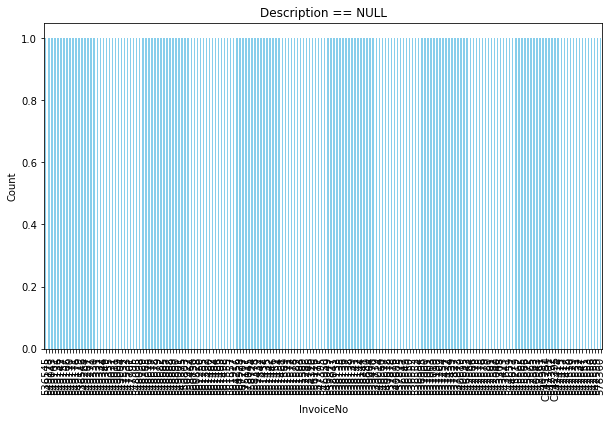

In [18]:
plt.figure(figsize=(10, 6))
invoice_counts.plot(kind='bar', color='skyblue')
plt.title('Description == NULL')
plt.xlabel('InvoiceNo')
plt.ylabel('Count')
plt.xticks()
plt.show()

- 제품명이 NULL 인 각 제품코드의 주문 건수는 모두 1임
    - 어떤상품인지 확인하기 어렵고 재주문 건수도 없으므로 해당 데이터는 삭제하기로 함

## 상품명 NuLL인 데이터 행 삭제

In [19]:
df = df.dropna(subset=['Description'])

In [20]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134922
Country             0
TotalPrice          0
dtype: int64

## 구매 날짜 시간 나누기

- 현재 날짜 데이터는 년-월-일 시:분:초 하나로 묶여져있음
- 기간별 코호트 분석을 위해 년-월-일 과 시:분:초 컬럼으로 나누는 것이 좋겠다고 생각하였음

In [21]:
Date = []
for i in df["InvoiceDate"]:
    Date.append(i[:10])

Time = []
for i in df["InvoiceDate"]:
    Time.append(i[11:])

In [22]:
# 잘 나누어졌는지 확인
len(Date), len(Time)

(541725, 541725)

In [23]:
# Date, Time 파생변수 생성
df["Date"] = Date
df["Time"] = Time

df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

In [24]:
# 기존 구매 날짜 컬럼 삭제
df_pre = df.drop(columns=['InvoiceDate'])

In [25]:
# 데이터 확인
df_pre.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


In [26]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541725 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541725 non-null  object        
 1   StockCode    541725 non-null  object        
 2   Description  541725 non-null  object        
 3   Quantity     541725 non-null  int64         
 4   UnitPrice    541725 non-null  float64       
 5   CustomerID   406803 non-null  float64       
 6   Country      541725 non-null  object        
 7   TotalPrice   541725 non-null  float64       
 8   Date         541725 non-null  datetime64[ns]
 9   Time         541725 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 45.5+ MB


## 구매 취소건 삭제

- 구매취소 건은 고객 구매주기에 혼동을 줄 수 있으므로 삭제

In [27]:
# 구매 취소건 확인
df_pre[df_pre["TotalPrice"] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time
141,C536379,D,Discount,-1,27.50,14527.0,United Kingdom,-27.50,2010-12-01,09:41:00
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,-4.65,2010-12-01,09:49:00
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,-19.80,2010-12-01,10:24:00
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,-6.96,2010-12-01,10:24:00
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,-6.96,2010-12-01,10:24:00


- 주문 취소건은 InvoiceNo 컬럼이 C 로 시작하거나 Quantity 와 UnitPrice 컬럼이 0 보다 작다는 특징을 가지고 있음을 확인

In [28]:
# 구매취소건 행 필터링
cancled_filter = (
    df_pre['InvoiceNo'].str.startswith('C') |
    (df_pre['Quantity'] <= 0) |
    (df_pre['UnitPrice'] <= 0)
)

# 조건을 만족하는 행들을 제거
df_pre = df_pre[~cancled_filter]

In [29]:
# 잘 삭제 되었는지 확인
df_pre[df_pre["TotalPrice"] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time


## 상품 품목 카테고리화 

- 현재 데이터의 상품 종류는 3775 개 임을 확인
    - 기존 정보로는 고객마다 구매한 상품 차별성을 확인 하는 것이 어렵다고 판단
    - 상품 품목 카테고리화 진행
        - scikit-learn의 TF-IDF로 카테고리화 진행
        - 파레토 법칙에 따라 카테고리 개수를 정함

#### TF-IDF

- TF-IDF : 텍스트 데이터를 벡터화하여 각 단어의 중요도를 문서 내에서 평가하는 방식

<img src = './img/tfidf.jpg'>

#### 파레토 법칙

- 파레토 법칙 : 상위 20%가 전체 비중의 80%를 해낸다는 법칙

In [30]:
Descroption_num = df_pre["Description"].nunique()
print(Descroption_num)

3775


In [31]:
# 파레토 법칙
# 전체 데이터 20%
round(Descroption_num*0.2)

755

#### 파레토 법칙 검증 

In [32]:
# 상품명 기준으로 그룹화
top20p = df_pre.groupby(df_pre["Description"]).sum()

# TotalPrice 기준으로 내림차순 정렬
top20p = top20p.sort_values(by = 'TotalPrice', ascending=False)

# TotalPrice 상위 755개의 항목 선택
top_20p = top20p.head(755)

# 상위 755개의 'TotalPrice' 총합 계산
total_20p = top_20p['TotalPrice'].sum()
total_20p

<ipython-input-32-31bf7ec0dc27>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top20p = df_pre.groupby(df_pre["Description"]).sum()


8407005.92

In [33]:
# 취소건을 제외한 매출 총액
Total =round(df_pre['TotalPrice'].sum())

# 상위 20% 품목의 수익률
print(f"전제 대비 상위 20% 품목의 매출액 : {round(total_20p/Total, 2)*100}%")

전제 대비 상위 20% 품목의 매출액 : 79.0%


- 매출액 상위 20% 항목이 전체 매출액의 79% 를 차지 하고 있음
- 파레토 법칙 성립

##  상품명 카테고리화 진행

In [34]:
# TF-IDF 모델 생성
N = 755  # 상위 N개의 키워드 추출
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_pre['Description'])

# 각 단어에 대한 TF-IDF 값 추출
tfidf_scores = tfidf_matrix.sum(axis=0)

# TF-IDF 값이 높은 단어 순으로 정렬
df_tfidf = pd.DataFrame(tfidf_scores, columns=vectorizer.get_feature_names_out()).transpose()
df_tfidf.columns = ['tfidf_score']
df_tfidf = df_tfidf.sort_values(by='tfidf_score', ascending=False)

# 상위 N개의 키워드 추출
top_keywords = df_tfidf.head(N).index.tolist()
print(top_keywords)

# 'category' 열 생성 및 할당
df_pre['Category'] = df_pre['Description'].apply(lambda x: next((keyword for keyword in top_keywords if keyword in x.lower()), None))


['bag', 'set', 'red', 'retrospot', 'heart', 'vintage', 'design', 'pink', 'jumbo', 'christmas', 'lunch', 'box', 'cake', 'metal', 'white', 'blue', 'light', 'hanging', 'holder', 'sign', 'pack', 'polkadot', 'paper', 'card', 'decoration', 'small', 'spaceboy', 'wooden', 'cases', 'tea', 'bottle', 'glass', '12', 'bunting', 'hot', 'paisley', 'large', 'water', 'tin', 'regency', 'pantry', 'doormat', 'wicker', 'dolly', 'party', 'green', 'ceramic', 'rose', 'charlotte', 'love', 'girl', 'ivory', 'home', 'mini', 'mug', 'wrap', 'woodland', 'black', 'cream', 'bowl', 'clock', 'childrens', 'feltcraft', 'strawberry', 'tins', 'fairy', 'assorted', 'kit', 'star', 'doily', 'suki', 'birthday', 'garden', 'skull', 'frame', '60', 'colour', 'antique', 'cutlery', 'silver', 'bird', 'zinc', 'wall', 'drawer', '50', 'hearts', 'wood', 'lights', 'cup', 'gift', 'hand', '20', 'storage', 'union', 'chocolate', 'london', 'alarm', 'jam', 'apples', 'tree', 'ribbons', 'jar', 'bakelike', 'candles', 'alphabet', 'warmer', 'flower', 

In [35]:
df_pre.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00,heart
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,metal
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12-01,08:26:00,heart
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,red


In [36]:
df_pre.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
UnitPrice           0
CustomerID     132216
Country             0
TotalPrice          0
Date                0
Time                0
Category          270
dtype: int64

- Category 컬럼에 270 개의 결측치 확인

### 상품 카테고리 Null 인 데이터 확인

In [37]:
df_pre[df_pre["Category"].isna()]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Category
4592,536796,21025,SPACE FROG,1,1.25,15574.0,United Kingdom,1.25,2010-12-02,15:46:00,None
6213,536876,21025,SPACE FROG,2,2.51,NaN,United Kingdom,5.02,2010-12-03,11:36:00,None
8591,537140,62018,SOMBRERO,1,1.95,12748.0,United Kingdom,1.95,2010-12-05,12:53:00,None
8811,537153,21025,SPACE FROG,10,1.25,16718.0,United Kingdom,12.50,2010-12-05,13:03:00,None
8900,537155,62018,SOMBRERO,1,1.95,12748.0,United Kingdom,1.95,2010-12-05,13:05:00,None
...,...,...,...,...,...,...,...,...,...,...,...
526230,580656,84356,POMPOM CURTAIN,1,1.95,15621.0,United Kingdom,1.95,2011-12-05,13:40:00,None
530415,580865,84199,GLOW IN DARK DOLPHINS,2,0.21,17914.0,United Kingdom,0.42,2011-12-06,11:58:00,None
532144,580983,21025,SPACE FROG,1,2.46,NaN,United Kingdom,2.46,2011-12-06,16:26:00,None
532680,580985,62018,SOMBRERO,6,1.95,17389.0,United Kingdom,11.70,2011-12-06,16:33:00,None


In [38]:
df_pre[df_pre["Category"].isna()]["Description"].value_counts()

POMPOM CURTAIN                82
SOMBRERO                      61
SPACE FROG                    56
GLOW IN DARK DOLPHINS         33
HAWAIIAN GRASS SKIRT          28
High Resolution Image          3
Dad's Cab Electronic Meter     2
AMAZON FEE                     2
SAMPLES                        2
Adjust bad debt                1
Name: Description, dtype: int64

In [39]:
# Category 가 Null 인 항목들의 총 매출
na = df_pre[df_pre["Category"].isna()]["TotalPrice"].sum()

print(f"카테고리 분류 Null 의 매출 비중: {round((na/Total)*100, 2)}%")

카테고리 분류 Null 의 매출 비중: 0.31%


- 카테고리 분류 Null 의 매출 비중이 0.34% 으로 적음
    - 고객유치와 매출 상승을 위한 전략으로 사용하기에 부적합 하다고 판단
    - 삭제 결정

In [40]:
# Category 가 Null 인 데이터 삭제
df_pre = df_pre[~df_pre["Category"].isna()]

# 삭제 확인
df_pre["Category"].isna().sum()

0

## 외국인 비회원 데이터 분석

- 현재 데이터에는 전체 구매 건수의 25%가 비회원 고객이다
- 우리 서비스는 본토인 영국 뿐 아니라 여러 유럽권 국가에서도 사용하고 있다.
    - 따라서 외국인은 비회원 고객이 많을 것이라는 가설을 세웠고
    - 만약 가설이 성립한다면 외국인 데이터는 삭제할 예정이다. <br><br>
    
- 가설 : 비회원 고객 비율은 **영국 < 외국** 일것이다

In [41]:
# 영국 총 주문건수
UK = len(df_pre[df_pre["Country"] == 'United Kingdom'])

# 외국 총 주문건수
foreigner = len(df_pre[df["Country"] != 'United Kingdom'])

print(UK, foreigner)

# 영국 비회원 주문건수
UK_non = df_pre[df_pre["Country"] == 'United Kingdom']["CustomerID"].isna().sum()

# 외국 비회원 주문건수
for_non = df_pre[df_pre["Country"] != 'United Kingdom']["CustomerID"].isna().sum()

print(UK_non, for_non)

print(f'영국인 비회원 고객 비율 : {round((UK_non / UK)*100, 2)}%')
print(f'외국인 비회원 고객 비율 : {round((for_non / foreigner)*100, 2)}%')

484842 44964
130707 1418
영국인 비회원 고객 비율 : 26.96%
외국인 비회원 고객 비율 : 3.15%


<ipython-input-41-812f040d925b>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  foreigner = len(df_pre[df["Country"] != 'United Kingdom'])


- tableau 로 시각화
<img src = "./img/국가별 비회원 고객비율.png"> <br><br>

- 외국이 비회원 고객 비율이 높을 줄 알았지만 영국이 더 높으므로 가설 기각
- 따라서 외국인 데이터 포함하기로 함

## 고객 재구매 주기 분석

- cohort 기간을 결정하기 위한 고객 재구매 주기 분석

### 각 고객의 이전 구매 날짜 파생 변수 생성

In [42]:
# 'Date'를 datetime 형식으로 변환
df_pre['Date'] = pd.to_datetime(df_pre['Date'])

# 고객별로 구매 날짜를 정렬
df_filtered = df_pre.sort_values(by=['CustomerID', 'Date'])

# 각 고객의 이전 구매 날짜 계산
df_filtered['PreviousPurchaseDate'] = df_filtered.groupby('CustomerID')['Date'].shift(1)

# NaN 값을 제외하고 재구매 주기 계산
df_filtered['RepurchaseInterval'] = df_filtered['Date'] - df_filtered['PreviousPurchaseDate']

# 결과 출력
print(f"주문 취소건을 제외 주문건 수 : {len(df_filtered)}(건)")
df_filtered.head()

주문 취소건을 제외 주문건 수 : 529806(건)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Category,PreviousPurchaseDate,RepurchaseInterval
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,77183.6,2011-01-18,10:01:00,ceramic,NaT,NaT
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2.10,12347.0,Iceland,25.2,2010-12-07,14:57:00,light,NaT,NaT
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,4.25,12347.0,Iceland,17.0,2010-12-07,14:57:00,bag,2010-12-07,0 days
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,3.25,12347.0,Iceland,39.0,2010-12-07,14:57:00,light,2010-12-07,0 days
14941,537626,22492,MINI PAINT SET VINTAGE,36,0.65,12347.0,Iceland,23.4,2010-12-07,14:57:00,set,2010-12-07,0 days


In [43]:
# 고객별 평균 재구매 주기 계산 (NaN 값은 무시됨)
repurchase_max = df_filtered['RepurchaseInterval'].dropna().dt.days.max()
repurchase_min = df_filtered['RepurchaseInterval'].dropna().dt.days.min()
repurchase_mean = df_filtered['RepurchaseInterval'].dropna().dt.days.mean()
repurchase_median = df_filtered['RepurchaseInterval'].dropna().dt.days.median()

# 결과 출력
print(f"고객별 재구매 주기 최댓값: {repurchase_max}일")
print(f"고객별 재구매 주기 최솟값: {repurchase_min}일")
print(f"고객별 재구매 주기 평균값: {repurchase_mean}일")
print(f"고객별 재구매 주기 중앙값: {repurchase_median}일")

고객별 재구매 주기 최댓값: 366일
고객별 재구매 주기 최솟값: 0일
고객별 재구매 주기 평균값: 1.4416058208590954일
고객별 재구매 주기 중앙값: 0.0일


- 한번만 구매한 사람도 있어서 평균값과 중앙값이 너무 낮음

In [44]:
# 첫구매 제외하기
df_filtered2 = df_filtered.dropna(subset=['RepurchaseInterval'])

# 같은날 구매 제외하기
df_filtered2 = df_filtered2[~(df_filtered2['RepurchaseInterval'] == '0days')]

# 하루단위를 정수로 변환(1days -> 1.0)
interval_data = (df_filtered2['RepurchaseInterval'] / pd.Timedelta(days=1)).astype(int)

### 고객 구매주기 시각화

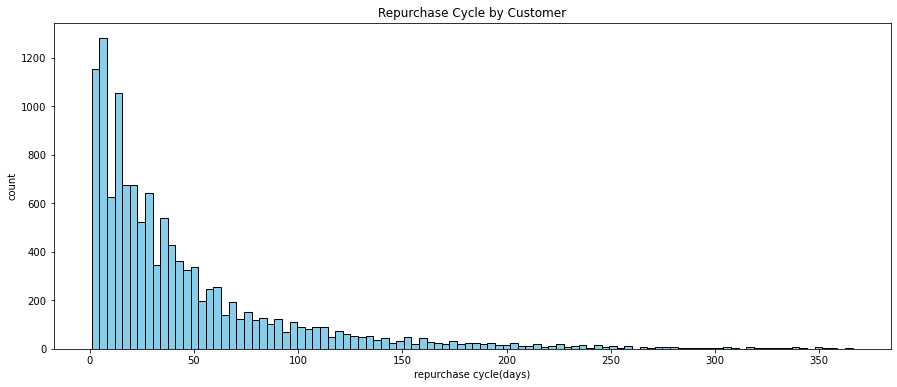

In [45]:
# 고객 재구매주기 그래프 
plt.figure(figsize=(15, 6)) 
plt.hist(interval_data, bins=100, color='skyblue', edgecolor='black')

plt.title('Repurchase Cycle by Customer')
plt.xlabel('repurchase cycle(days)')
plt.ylabel('count')
plt.show()

### 고객 구매주기 이상치 확인

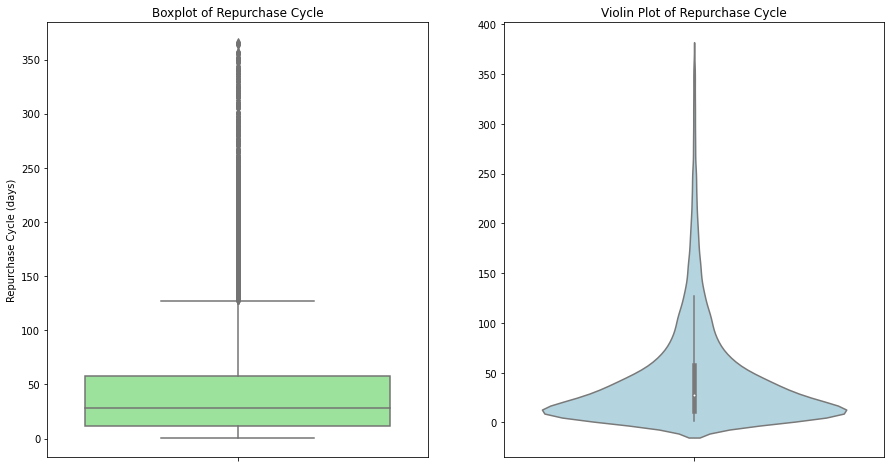

In [46]:
plt.figure(figsize=(15, 8))

# 박스플롯
plt.subplot(1, 2, 1)  
sns.boxplot(y=interval_data, color='lightgreen')
plt.title('Boxplot of Repurchase Cycle')
plt.ylabel('Repurchase Cycle (days)')

# 항아리 그래프
plt.subplot(1, 2, 2)  
sns.violinplot(y=interval_data, color='lightblue')
plt.title('Violin Plot of Repurchase Cycle')
plt.ylabel('') 

plt.show()

### 고객 구매주기 평균/중앙 값

In [47]:
mean = interval_data.mean()
median = interval_data.median()

print(f"재구매 주기 평균값 : {round(mean)}일")
print(f"재구매 주기 중앙값 : {round(median)}일")

재구매 주기 평균값 : 46일
재구매 주기 중앙값 : 28일


- Q1~Q3 범위에 들어오는 값들과 이상치의 수치가 너무 많이 차이 남
- 평균값은 이상치에 영향을 많이 받으므로 재구매 주기 기준은 중앙값을 사용하기로 함
    - cohort 의 기간은 중앙값과 유사한 **1달** 단위로 결정함 

In [48]:
# df_pre.to_csv('./data/Online_Retail(전처리 후).csv', index=False)

In [49]:
# conn = sqlite3.connect('Online_Retail.db')

# df_pre.to_sql('Online_Retail', conn, if_exists='replace', index=False)

# conn.close()